# Azure predictive maintenance
This notebook shows an example of multiple ways in tackling a predictive maintenance problem (LTSM, RNN, RFC), while utilizing mlflow for experiment tracking. This notebook shows the creation of the model. Other files will show the deployment of the best performing model using FastAPI.

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dense, Dropout
from tensorflow.keras import losses, callbacks
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint

## Data
The dataset is the Microsoft Azure Predictive Maintenance dataset. This was data was downloaded from Kaggle (https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance?resource=download).


In [18]:
df_path = "data/"

df_tele = pd.read_csv(df_path + 'PdM_telemetry.csv')
df_fail = pd.read_csv(df_path + 'PdM_failures.csv')
df_err = pd.read_csv(df_path + 'PdM_errors.csv')
df_maint = pd.read_csv(df_path + 'PdM_maint.csv')


Since this is a demonstration only, we will focus on one of the machines. In this case, we chose machine 11.

In [19]:
df_sel = df_tele.loc[df_tele['machineID'] == 11].reset_index(drop=True)
sel_fail = df_fail.loc[df_fail['machineID'] == 11]
sel_err = df_err.loc[df_err['machineID'] == 11]

In [20]:
sel_fail

,datetime,machineID,failure
58,2015-01-20 06:00:00,11,comp2
59,2015-02-19 06:00:00,11,comp3
60,2015-04-20 06:00:00,11,comp2
61,2015-04-20 06:00:00,11,comp3
62,2015-10-02 06:00:00,11,comp3
63,2015-12-16 06:00:00,11,comp3


In [21]:

# Select the date to check from failure records
df_sel['datetime'] = pd.to_datetime(df_sel['datetime'])
st_train = df_sel.loc[df_sel['datetime'] == "2015-02-19"].index.values[0]

# Then, filter the data to include approximately one month window
start_period = st_train - 14*24
end_period = st_train + 14*24

def create_feature(start, end):
  # create features from the selected machine
  pressure = df_sel.loc[start: end, 'pressure']
  timestamp = pd.to_datetime(df_sel.loc[start: end, 'datetime'])
  timestamp_hour = timestamp.map(lambda x: x.hour)
  timestamp_dow = timestamp.map(lambda x: x.dayofweek)

  # apply one-hot encode for timestamp data
  timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()

  # apply min-max scaler to numerical data
  scaler = MinMaxScaler()
  pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))

  # combine features into one
  feature = np.concatenate([pressure, timestamp_hour_onehot], axis=1)

  X = feature[:-1]
  y = np.array(feature[5:,0]).reshape(-1,1)

  return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)

In [8]:
def shape_sequence(arr, step, start):
    out = list()
    for i in range(start, arr.shape[0]):
        low_lim = i
        up_lim = low_lim + step
        out.append(arr[low_lim: up_lim])

        if up_lim == arr.shape[0]:
          # print(i)
          break

    out_seq = np.array(out)
    return out_seq

# Shape the sequence according to the length specified
X_seq = shape_sequence(X, 5, 0)
y_seq = shape_sequence(y, 1, 0)

# Separate the input and output for train and validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training data shape = ", X_train.shape)
print("Validation data shape = ", X_val.shape)

Training data shape =  (534, 5, 25)
Validation data shape =  (134, 5, 25)


Epoch 1/500


/Users/zeidsmac/miniforge3/envs/Transformers/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1966
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1110
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0533
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0225
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0199
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0193
Epoch 9/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0196
Epoch 10/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0201
Epoch 11/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0180
Epoch 12/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0188
Epoch 13/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0183
Epoch 14/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0190
Epoch 15/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0191
E

2025/03/02 23:44:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/02 23:44:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x380117380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Validation error (LSTM) =  0.014624182


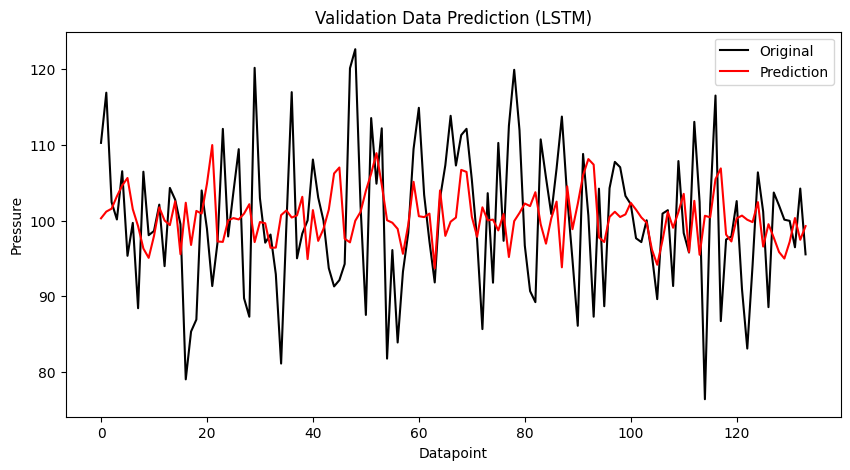

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing error (LSTM) =  0.03164602


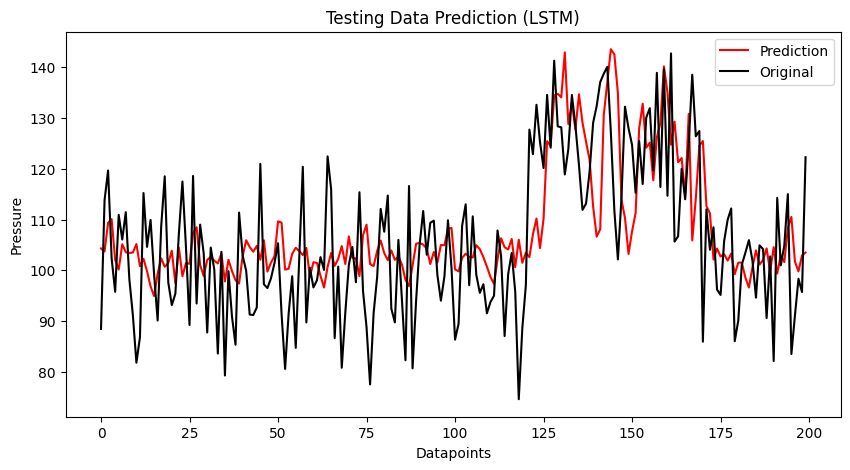

Epoch 1/500


/Users/zeidsmac/miniforge3/envs/Transformers/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.1766
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0947
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0657
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0496
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0396
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0336
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0343
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0309
Epoch 9/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0292
Epoch 10/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0275
Epoch 11/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0273
Epoch 12/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0263
Epoch 13/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0266
Epoch 14/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0263
Epoch 15/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0244
E

2025/03/03 02:06:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/03 02:07:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Validation error (RNN) =  0.016507791


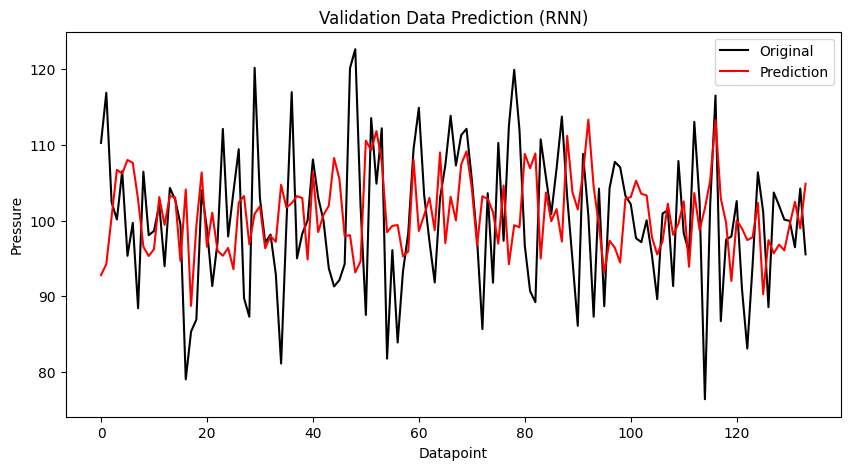

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing error (RNN) =  0.034548856


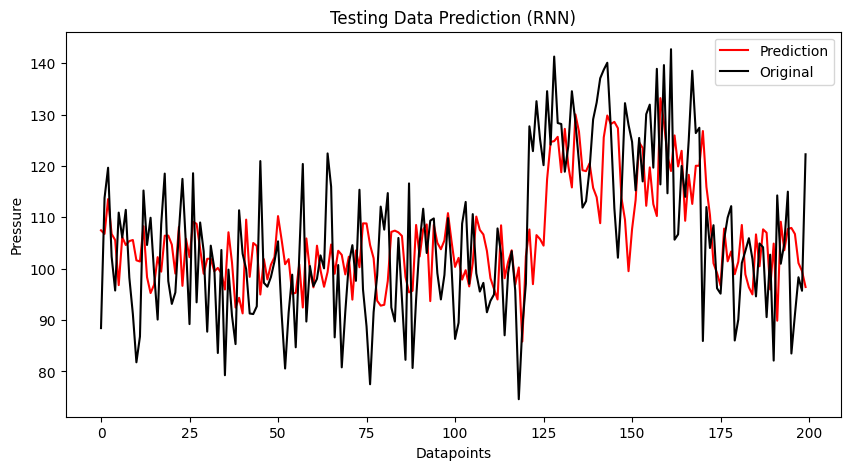

In [23]:
def train_validate_test_model(model_type, X_train, y_train, X_val, y_val, X_test, y_test, pres_scaler, test_scaler):
    shape = X_train.shape[1]
    feat_length = X_train.shape[2]

    model = Sequential()

    if model_type == "LSTM":
        model.add(LSTM(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
        model.add(LSTM(shape, activation='tanh', return_sequences=False))
    elif model_type == "RNN":
        model.add(SimpleRNN(shape, activation='tanh', input_shape=(shape, feat_length), return_sequences=True))
        model.add(SimpleRNN(shape, activation='tanh', return_sequences=False))
    
    model.add(Dense(shape, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer="Adam", loss=MeanSquaredError())

    # Start MLflow tracking
    with mlflow.start_run(run_name=f"{model_type}_run"):
        mlflow.log_param("model_type", model_type)
        mlflow.log_param("units", shape)
        mlflow.log_param("activation", "tanh")
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("epochs", 500)

        # Define a callback to log training loss at each epoch
        class MLflowCallback(callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if logs:
                    mlflow.log_metric("train_loss", logs["loss"], step=epoch)

        # Train model with MLflow logging
        model.fit(X_train, y_train, verbose=1, epochs=500, callbacks=[MLflowCallback()])

        # Log the final model
        mlflow.tensorflow.log_model(model, f"{model_type}_model")

        # ---- Validation ----
        y_pred_val = model.predict(X_val)
        mse = MeanSquaredError()
        val_err = mse(y_val.reshape(-1, 1), y_pred_val).numpy()
        print(f"Validation error ({model_type}) = ", val_err)

        # Log validation error to MLflow
        mlflow.log_metric("validation_mse", val_err)

        # Inverse transform for better observation
        y_val_inv = pres_scaler.inverse_transform(y_val.reshape(-1, 1))
        y_pred_val_inv = pres_scaler.inverse_transform(y_pred_val.reshape(-1, 1))

        # Plot validation results
        plt.figure(figsize=(10, 5))
        plt.plot(y_val_inv, 'k', label='Original')
        plt.plot(y_pred_val_inv, 'r', label='Prediction')
        plt.ylabel("Pressure")
        plt.xlabel("Datapoint")
        plt.title(f"Validation Data Prediction ({model_type})")
        plt.legend()

        # Save and log the plot
        val_plot_path = f"{model_type}_validation_plot.png"
        plt.savefig(val_plot_path)
        plt.show()

        mlflow.log_artifact(val_plot_path)

        # ---- Testing ----
        y_pred_test = model.predict(X_test)
        test_err = mse(y_test.reshape(-1,1), y_pred_test).numpy()
        print(f"Testing error ({model_type}) = ", test_err)

        # Log testing error
        mlflow.log_metric("testing_mse", test_err)

        # Select first 200 data points for plotting
        y_pred_test_inv = test_scaler.inverse_transform(y_pred_test[:200].reshape(-1, 1))
        y_test_inv = test_scaler.inverse_transform(y_test[:200].reshape(-1, 1))

        # Plot testing results
        plt.figure(figsize=(10, 5))
        plt.plot(y_pred_test_inv, 'r', label='Prediction')
        plt.plot(y_test_inv, 'k', label='Original')
        plt.ylabel("Pressure")
        plt.xlabel("Datapoints")
        plt.legend()
        plt.title(f"Testing Data Prediction ({model_type})")

        # Save and log the plot
        test_plot_path = f"{model_type}_testing_plot.png"
        plt.savefig(test_plot_path)
        plt.show()

        mlflow.log_artifact(test_plot_path)

    return model

# ---- Preprocessing Test Data ----
st_test = df_sel.loc[df_sel['datetime'] == "2015-04-20"].index.values[0]
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler = create_feature(start_period_test, end_period_test)

# Reshape sequences for model input
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

# Train, validate, and test both models
lstm_model = train_validate_test_model("LSTM", X_train, y_train, X_val, y_val, X_test_seq, y_test_seq, pres_scaler, test_scaler)
rnn_model = train_validate_test_model("RNN", X_train, y_train, X_val, y_val, X_test_seq, y_test_seq, pres_scaler, test_scaler)